In [ ]:
import pandas as pd

# Load the CSV file
file_path = "B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/processed_ppmi_master_dataset_V2.csv"
data = pd.read_csv(file_path)

# Define mapping for replacement
# replacement_map = {
#     '0 months': 'V1',
#     '5-17 months': 'V2',
#     '18-30 months': 'V3',
#     '31-65 months': 'V4'
# }
replacement_map = {
    '0 months': 'V1',
    '5-10 months V1':'V21',
    '11-17 months V1':'V22',
    '18-23 months V2':'V31',
    '24-30 months V2':'V32',
    '31-40 months V3': 'V41',
    '41-65 months V3': 'V42'
}
# Replace values in 'Visit Class' column
data['Visit Class'] = data['Visit Class'].replace(replacement_map)

# Save the updated DataFrame back to CSV
updated_file_path = "B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/processed_ppmi_master_dataset_V2.csv"
data.to_csv(updated_file_path, index=False)

print("Values replaced and CSV updated successfully.")

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input
# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/processed_ppmi_master_dataset_V2.csv")
# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'EVENT_ID', 'VisitNumber']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy'
]
categorical_features = [
    'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 
    'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 
    'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 
    'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 
    'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 
    'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2SPCH', 'NP2SALV', 
    'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 
    'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 
    'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP1COG', 'NP1HALL', 'NP1DPRS', 
    'NP1ANXS', 'NP1APAT', 'NP1DDS', 'CONCOHORT'
]
target_columns = "Visit Class"
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Visit Class)
data = pd.get_dummies(data, columns=['Visit Class'], drop_first=False)
import numpy as np

sequences = []
targets = []

grouped = data.groupby('Patient ID')

import numpy as np


def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets



# Get updated list of target columns after one-hot encoding
target_columns = list(data.filter(regex='Visit Class').columns)
# Create sequences
sequences, targets = create_sequences(data, non_feature_columns,numerical_features,categorical_features, target_columns)
print(sequences.shape)
# Convert sequences and targets to numpy arrays
X = np.array(sequences)
print(X.shape)
y = np.array(targets)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
# Define LSTM model for sequence of 4 visits per patient
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)  # Only one LSTM layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Train LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


# Evaluate LSTM model on training and testing sets
lstm_train_loss, lstm_train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)



print(f"LSTM - Train Loss: {lstm_train_loss}, Train Accuracy: {lstm_train_accuracy}")
print(f"LSTM - Test Loss: {lstm_test_loss}, Test Accuracy: {lstm_test_accuracy}")


(216, 4, 87)
(216, 4, 87)
(172, 4, 87) (44, 4, 87)
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2689 - loss: 1.7892   
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.8644 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.3946 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.1928 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.1993 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.1905 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.1172 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.1781 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.1045 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.1049 
LSTM - Train Loss: 0.10402584820985794, Train Accuracy: 0.9825581312179565
LSTM - Test Loss: 0.01562551222741604, Te

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 7s 785us/step


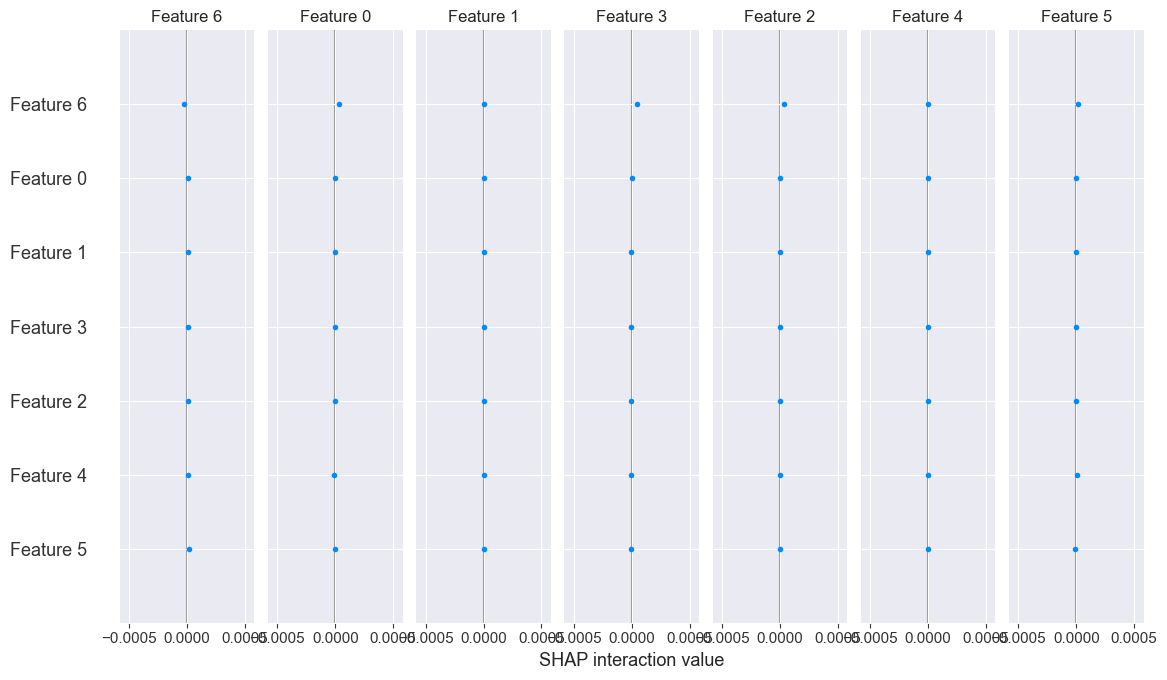

In [36]:
import shap
from lime.lime_tabular import LimeTabularExplainer
max_sequence_length = max([len(seq) for seq in sequences])
# Flatten the input data for SHAP
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Function to predict using the LSTM model with reshaped input
def lstm_predict(data):
    data_3d = data.reshape((data.shape[0], max_sequence_length, X_train.shape[2]))
    return lstm_model.predict(data_3d)

# Select the last trained LSTM model for SHAP explanations
explainer = shap.KernelExplainer(lstm_predict, X_train_2d[:100])
shap_values = explainer.shap_values(X_test_2d[:1])

shap.summary_plot(shap_values, X_test_2d[:1])

In [37]:
lstm_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[1.7360256e-03, 2.1895226e-03, 8.8550855e-04, 1.7092007e-03,
        1.8380519e-03, 4.2921095e-03, 9.8734957e-01],
       [2.8260155e-03, 2.3740446e-03, 1.1172016e-03, 1.9208987e-03,
        2.0796256e-03, 3.3595590e-03, 9.8632264e-01],
       [3.1858087e-03, 4.3079513e-03, 1.9391360e-03, 3.0618520e-03,
        2.9305513e-03, 6.9232052e-03, 9.7765154e-01],
       [1.8895559e-03, 2.1868043e-03, 8.4636378e-04, 1.5427555e-03,
        1.7544919e-03, 3.2863501e-03, 9.8849374e-01],
       [1.7341966e-03, 1.3044407e-03, 5.6871009e-04, 8.6750276e-04,
        1.1618286e-03, 1.4201446e-03, 9.9294311e-01],
       [3.3365160e-03, 2.3101454e-03, 1.0288495e-03, 1.7906701e-03,
        2.3035696e-03, 2.6488402e-03, 9.8658144e-01],
       [3.2981909e-03, 2.6133438e-03, 1.1283292e-03, 2.4438340e-03,
        2.3957065e-03, 4.6849283e-03, 9.8343569e-01],
       [1.3772928e-02, 8.6604208e-03, 6.0311998e-03, 8.2731051e-03,
        1.1823605e-02, 1.5010455e-02, 9.3642831e-01],
       [3.5375583e-03, 4

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<Figure size 1000x800 with 0 Axes>

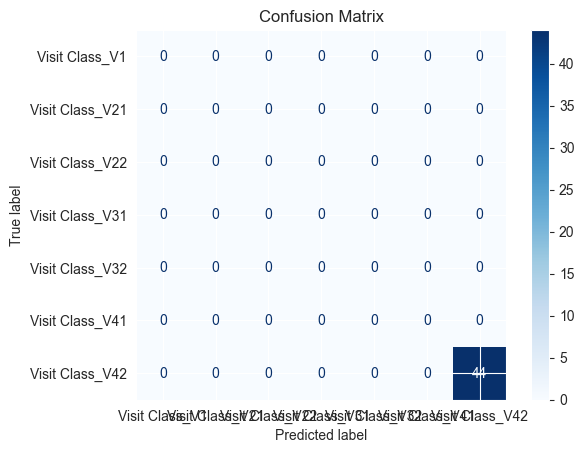

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(len(target_columns)))

# Define class names (assuming you have them in target_columns)
class_names = target_columns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [39]:
print(X_test.shape)

(44, 4, 87)


In [40]:
print((X_train.shape[1], X_train.shape[2]), len(target_columns))

(4, 87) 7


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6745 - loss: 1.0390
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9756 - loss: 0.3056 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9849 - loss: 0.1549 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0853 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9737 - loss: 0.1730 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9804 - loss: 0.1149 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9778 - loss: 0.1327 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9860 - loss: 0.0869 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9897 - loss: 0.0728 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9884 - loss: 0.0589 
SimpleRNN - Train Loss: 0.08715386688709259, Train Accuracy: 0.9825581312179565
SimpleRNN - Test Loss: 0.013161984272301197, Test Accuracy: 1.0


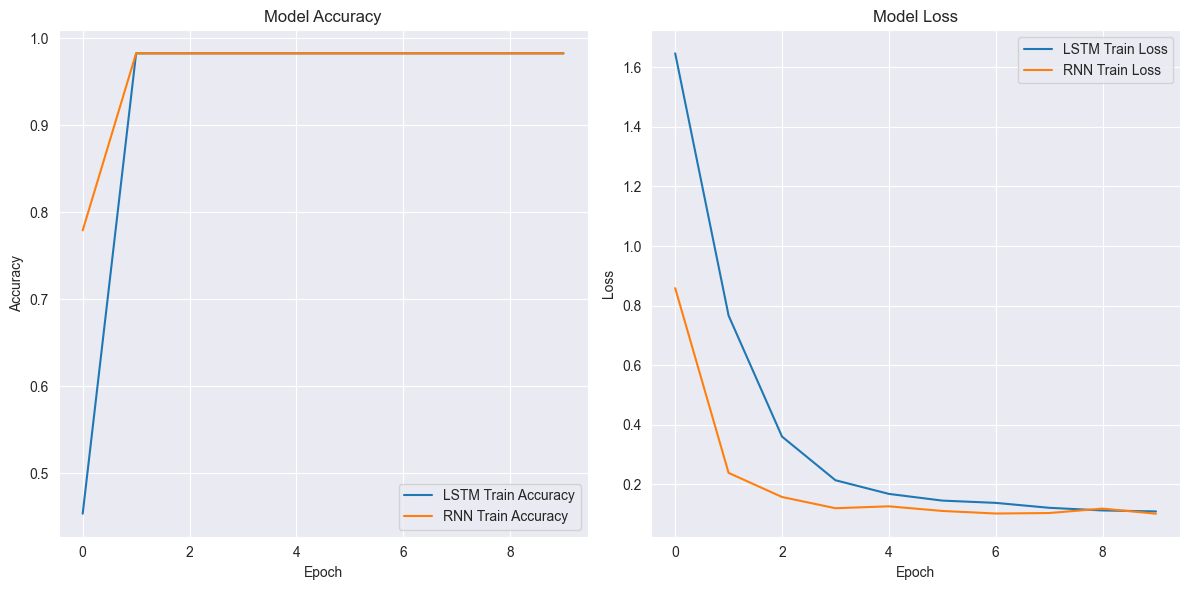

In [41]:
# Define SimpleRNN model for sequence of 4 visits per patient
def create_rnn_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(50)(inputs)  # Only one SimpleRNN layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train SimpleRNN model
rnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate SimpleRNN model on training and testing sets
rnn_train_loss, rnn_train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"SimpleRNN - Train Loss: {rnn_train_loss}, Train Accuracy: {rnn_train_accuracy}")
print(f"SimpleRNN - Test Loss: {rnn_test_loss}, Test Accuracy: {rnn_test_accuracy}")

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:


# Predict using rnn_model
import numpy as np

# Predict using rnn_model
predictions = rnn_model.predict(X_test)

# Print predictions formatted to three decimal places
formatted_predictions = np.around(predictions, decimals=3)

# Print formatted predictions without flattening
for row in formatted_predictions:
    print([f"{val:.3f}" for val in row])



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
['0.000', '0.000', '0.003', '0.001', '0.001', '0.004', '0.991']
['0.001', '0.000', '0.001', '0.000', '0.001', '0.006', '0.990']
['0.000', '0.000', '0.001', '0.001', '0.001', '0.002', '0.995']
['0.000', '0.000', '0.001', '0.001', '0.002', '0.007', '0.989']
['0.000', '0.000', '0.001', '0.000', '0.000', '0.002', '0.996']
['0.001', '0.000', '0.003', '0.001', '0.001', '0.007', '0.988']
['0.002', '0.001', '0.004', '0.001', '0.001', '0.007', '0.984']
['0.002', '0.001', '0.006', '0.002', '0.002', '0.005', '0.982']
['0.001', '0.000', '0.004', '0.001', '0.002', '0.005', '0.988']
['0.001', '0.000', '0.001', '0.000', '0.002', '0.004', '0.991']
['0.001', '0.000', '0.002', '0.001', '0.007', '0.005', '0.985']
['0.001', '0.000', '0.003', '0.001', '0.003', '0.005', '0.986']
['0.001', '0.000', '0.001', '0.000', '0.002', '0.002', '0.994']
['0.000', '0.000', '0.001', '0.000', '0.001', '0.003', '0.995']
['0.001', '0.000', '0.002', '0.001', '0.001', '0.005', '0.989']
['

In [51]:
def plot_confusion_matrix(y_true, y_pred, target_columns):
    """
    Plot a confusion matrix using sklearn's ConfusionMatrixDisplay.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - target_columns (list): List of target class names.

    Returns:
    - None
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(target_columns)))
    
    # Define class names
    class_names = target_columns
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/processed_ppmi_master_dataset_V2.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'EVENT_ID', 'VisitNumber']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy'
]
categorical_features = [
    'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 
    'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 
    'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 
    'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 
    'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 
    'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2SPCH', 'NP2SALV', 
    'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 
    'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 
    'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP1COG', 'NP1HALL', 'NP1DPRS', 
    'NP1ANXS', 'NP1APAT', 'NP1DDS', 'CONCOHORT'
]

# Preprocess numerical features with MinMaxScaler
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Visit Class)
data = pd.get_dummies(data, columns=['Visit Class'], drop_first=False)

def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Get updated list of target columns after one-hot encoding
target_columns = list(data.filter(regex='Visit Class').columns)

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Initialize KFold with number of splits (e.g., 5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
fold_data = []

# Loop through each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define LSTM model
    lstm_model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(len(target_columns), activation='softmax')
    ])
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train LSTM model
    lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    # Evaluate LSTM model on training set
    train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
    print(f"Fold {i+1} Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
    # Evaluate LSTM model on test set
    test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {i+1} Testing Loss: {test_loss}, Testing Accuracy: {test_accuracy}")
    # Save fold data
    fold_data.append({
        'fold_index': i+1,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })
    # y_pred = lstm_model.predict(X_test)
    # y_pred_classes = np.argmax(y_pred, axis=1)
    # y_true_classes = np.argmax(y_test, axis=1)
    # plot_confusion_matrix(y_true_classes, y_pred_classes, target_columns)

# Print average metrics across all folds
print(f"Average Train Loss: {np.mean([fold['train_loss'] for fold in fold_data])}")
print(f"Average Train Accuracy: {np.mean([fold['train_accuracy'] for fold in fold_data])}")
print(f"Average Test Loss: {np.mean([fold['test_loss'] for fold in fold_data])}")
print(f"Average Test Accuracy: {np.mean([fold['test_accuracy'] for fold in fold_data])}")


Epoch 1/10


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7653 - loss: 1.3042
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.4722 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.1795 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.1363 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0784 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.1199 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0703 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.1392 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.1007 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0681 
Fold 1 Training Loss: 0.08987957239151001, Training Accuracy: 0.9825581312179565
Fold 1 Testing Loss: 0.015041560865938663, Testing Accuracy: 1.0
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━

In [62]:
def create_rnn_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(50)(inputs)  # Only one SimpleRNN layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize KFold with number of splits (e.g., 5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Loop through each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create SimpleRNN model
    rnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    
    # Train SimpleRNN model
    rnn_history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    # Evaluate SimpleRNN model on training set
    rnn_train_loss, rnn_train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
    train_losses.append(rnn_train_loss)
    train_accuracies.append(rnn_train_accuracy)
    print(f"Fold {i+1} - SimpleRNN Train Loss: {rnn_train_loss}, Train Accuracy: {rnn_train_accuracy}")
    
    # Evaluate SimpleRNN model on test set
    rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
    test_losses.append(rnn_test_loss)
    test_accuracies.append(rnn_test_accuracy)
    print(f"Fold {i+1} - SimpleRNN Test Loss: {rnn_test_loss}, Test Accuracy: {rnn_test_accuracy}")
    predictions = rnn_model.predict(X_test)

    # Print predictions formatted to three decimal places
    formatted_predictions = np.around(predictions, decimals=3)

    # Print formatted predictions without flattening
    for row in formatted_predictions:
        print([f"{val:.3f}" for val in row])

# Print average metrics across all folds
print(f"Average Train Loss: {np.mean(train_losses)}")
print(f"Average Train Accuracy: {np.mean(train_accuracies)}")
print(f"Average Test Loss: {np.mean(test_losses)}")
print(f"Average Test Accuracy: {np.mean(test_accuracies)}")

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5786 - loss: 1.2288
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9819 - loss: 0.2868 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9815 - loss: 0.1715 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9853 - loss: 0.1195 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0850 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9897 - loss: 0.0733 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9875 - loss: 0.0772 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9711 - loss: 0.1597 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9827 - loss: 0.0973 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.0450 
Fold 1 - SimpleRNN Train Loss: 0.08397341519594193, Train Accuracy: 0.9825581312179565
Fold 1 - SimpleRNN Test Loss: 0.010499294847249985, Test Accuracy: 1.0
2/2 ━━━━━━━━

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,957 (11.55 KB)

 Trainable params: 2,957 (11.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2362 - loss: 1.7710 - val_accuracy: 0.2254 - val_loss: 1.6460
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2176 - loss: 1.6299 - val_accuracy: 0.2312 - val_loss: 1.6308
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2532 - loss: 1.6008 - val_accuracy: 0.2081 - val_loss: 1.6418
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2575 - loss: 1.5992 - val_accuracy: 0.2139 - val_loss: 1.6497
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2889 - loss: 1.5969 - val_accuracy: 0.2081 - val_loss: 1.6501
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2714 - loss: 1.6096 - val_accuracy: 0.2601 - val_loss: 1.6803
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2800 - loss: 1.5923 - val_accuracy: 0.2081 - val_loss: 1.6560
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2566 - loss: 1.6280 - val_accuracy: 0.2197 - val_loss

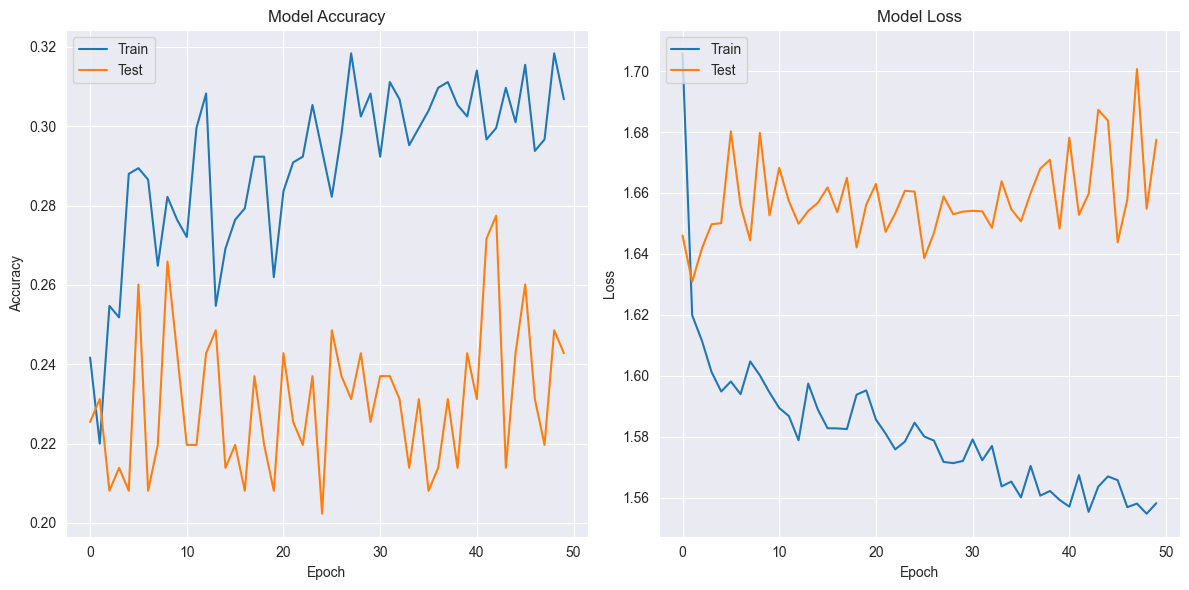

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/stepWARNING:tensorflow:5 out of the last 8558 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D4C974A3E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

          V1       0.26      0.67      0.38        36
         V21       0.00      0.00      0.00         6
         V22       0.14      0.05

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import numpy as np

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/processed_ppmi_master_dataset_V2.csv")

# Define columns
non_feature_columns = ['Patient ID', 'Visit Date', 'EVENT_ID', 'VisitNumber']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy'
]
categorical_features = [
    'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 
    'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 
    'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 
    'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 
    'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 
    'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2SPCH', 'NP2SALV', 
    'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 
    'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 
    'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP1COG', 'NP1HALL', 'NP1DPRS', 
    'NP1ANXS', 'NP1APAT', 'NP1DDS', 'CONCOHORT'
]
target_column = "Visit Class"

# Drop non-feature columns
data = data.drop(non_feature_columns, axis=1)

# Separate features and target
X = data[numerical_features].values
y = data[target_column].values.reshape(-1, 1)

# Normalize numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode target column
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define and train RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Reshape data for RNN input (samples, timesteps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_rnn, y_test), verbose=1)

# Evaluate the model
train_acc = model.evaluate(X_train_rnn, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test_rnn, y_test, verbose=0)[1]
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Calculate and print classification report
y_pred = np.argmax(model.predict(X_test_rnn), axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
print(classification_report(y_test_decoded, y_pred, target_names=encoder.categories_[0]))


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,757 (42.02 KB)

 Trainable params: 10,757 (42.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1778 - loss: 1.9141 - val_accuracy: 0.2081 - val_loss: 1.7448
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2712 - loss: 1.6508 - val_accuracy: 0.2254 - val_loss: 1.6393
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2583 - loss: 1.5805 - val_accuracy: 0.2081 - val_loss: 1.6523
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2673 - loss: 1.5958 - val_accuracy: 0.2139 - val_loss: 1.6421
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2468 - loss: 1.5840 - val_accuracy: 0.2081 - val_loss: 1.6395
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2502 - loss: 1.6015 - val_accuracy: 0.2081 - val_loss: 1.6421
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2554 - loss: 1.5964 - val_accuracy: 0.2081 - val_loss: 1.6461
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2854 - loss: 1.6153 - val_accuracy: 0.2254 - val_loss

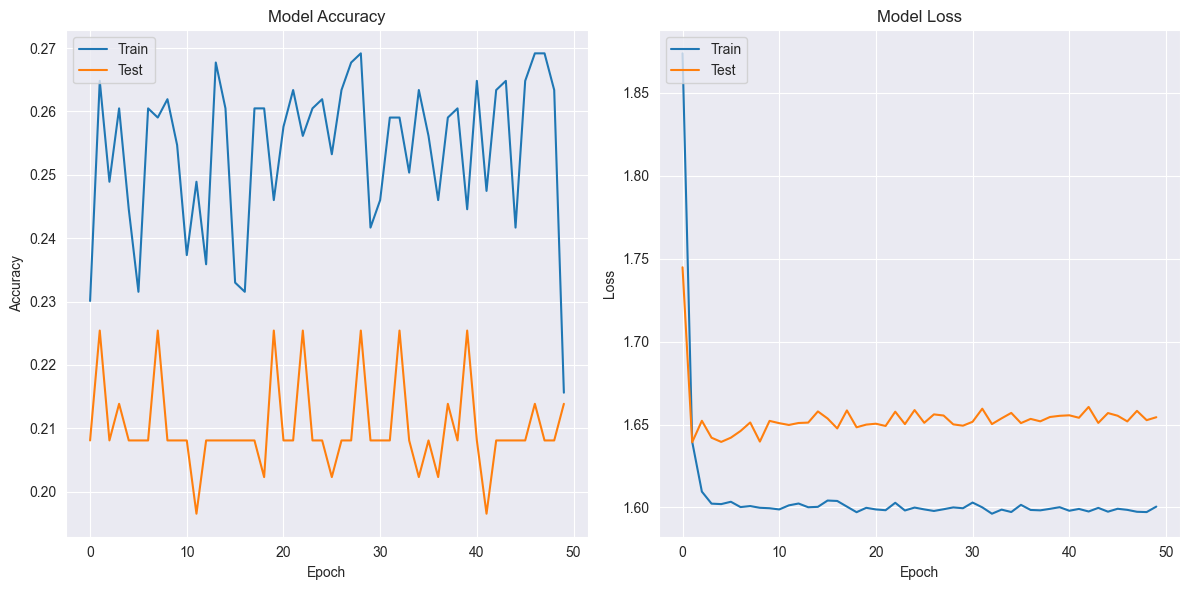

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [43]:
   import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/processed_ppmi_master_dataset_V2.csv")

# Define columns
non_feature_columns = ['Patient ID', 'Visit Date', 'EVENT_ID', 'VisitNumber']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy'
]
categorical_features = [
    'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 
    'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 
    'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 
    'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 
    'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 
    'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2SPCH', 'NP2SALV', 
    'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 
    'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 
    'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP1COG', 'NP1HALL', 'NP1DPRS', 
    'NP1ANXS', 'NP1APAT', 'NP1DDS', 'CONCOHORT'
]
target_column = "Visit Class"

# Drop non-feature columns
data = data.drop(non_feature_columns, axis=1)

# Separate features and target
X = data[numerical_features].values
y = data[target_column].values.reshape(-1, 1)

# Normalize numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode target column
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define and train LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Reshape data for LSTM input (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Evaluate the model
train_acc = model.evaluate(X_train_lstm, y_train, verbose=40)[1]
test_acc = model.evaluate(X_test_lstm, y_test, verbose=40)[1]
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Calculate and print classification report
y_pred = model.predict_classes(X_test_lstm)
y_test_decoded = np.argmax(y_test, axis=1)
print(classification_report(y_test_decoded, y_pred, target_names=encoder.categories_[0]))
